In [1]:
import json
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import cv2
import pandas as pd
import os
import numpy as np
import torch
import torch.optim as optim
import time

2024-07-28 16:11:31.042730: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-28 16:11:31.113640: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-28 16:11:31.592905: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Define the dataset directories
base_dir = 'fracatlas-DatasetNinja'
sets = ['train', 'val', 'test']

def filter_images_and_extract_info(set_name):
    ann_dir = os.path.join(base_dir, set_name, 'ann')
    img_dir = os.path.join(base_dir, set_name, 'img')
    
    data = []
    
    for ann_file in os.listdir(ann_dir):
        if ann_file.endswith('.json'):
            with open(os.path.join(ann_dir, ann_file)) as f:
                data_json = json.load(f)
                # Count the number of bounding boxes (geometryType: "rectangle")
                bboxes = [obj for obj in data_json['objects'] if obj['geometryType'] == 'rectangle']
                if len(bboxes) == 1:
                    bbox = bboxes[0]['points']['exterior']
                    xmin, ymin = bbox[0]
                    xmax, ymax = bbox[1]
                    width = data_json['size']['width']
                    height = data_json['size']['height']
                    img_file = ann_file.replace('.json', '')
                    img_path = os.path.join(img_dir, img_file)
                    data.append({
                        'filenamepath': img_path,
                        'width': width,
                        'height': height,
                        'xmin': xmin,
                        'ymin': ymin,
                        'xmax': xmax,
                        'ymax': ymax
                    })
    
    return data

def count_images(set_name):
    ann_dir = os.path.join(base_dir, set_name, 'ann')
    return len([f for f in os.listdir(ann_dir) if f.endswith('.json')])

def count_and_store_to_dataframe():
    all_data = []
    total_counts = {}
    filtered_counts = {}
    
    for set_name in sets:
        total_images = count_images(set_name)
        filtered_data = filter_images_and_extract_info(set_name)
        filtered_count = len(filtered_data)
        
        total_counts[set_name] = total_images
        filtered_counts[set_name] = filtered_count
        
        print(f"{set_name} set: {filtered_count}/{total_images} images with exactly one bounding box ({(filtered_count / total_images) * 100:.2f}%)")
        
        all_data.extend(filtered_data)
    
    # Create DataFrame
    df = pd.DataFrame(all_data)
    
    # Calculate ratios
    total_filtered_images = sum(filtered_counts.values())
    train_ratio = (filtered_counts['train'] / total_filtered_images) * 100
    val_ratio = (filtered_counts['val'] / total_filtered_images) * 100
    test_ratio = (filtered_counts['test'] / total_filtered_images) * 100
    
    ratios = {
        'train_ratio': train_ratio,
        'val_ratio': val_ratio,
        'test_ratio': test_ratio
    }
    
    print(f"Ratios (train:val:test): {train_ratio:.2f}% : {val_ratio:.2f}% : {test_ratio:.2f}%")
    
    return df, filtered_counts, ratios

# Execute the function to count, filter, and store data to a DataFrame
df_filtered_images, filtered_counts, ratios = count_and_store_to_dataframe()

train set: 418/574 images with exactly one bounding box (72.82%)
val set: 73/82 images with exactly one bounding box (89.02%)
test set: 55/61 images with exactly one bounding box (90.16%)
Ratios (train:val:test): 76.56% : 13.37% : 10.07%


In [3]:
df_filtered_images

,filenamepath,width,height,xmin,ymin,xmax,ymax
0,fracatlas-DatasetNinja/train/img/IMG0000019.jpg,2304,2880,1242,929,1515,1076
1,fracatlas-DatasetNinja/train/img/IMG0000025.jpg,2880,2304,1466,2010,1621,2163
2,fracatlas-DatasetNinja/train/img/IMG0000044.jpg,2304,2880,1426,1072,1570,1187
3,fracatlas-DatasetNinja/train/img/IMG0000057.jpg,2304,2880,1130,1119,1270,1219
4,fracatlas-DatasetNinja/train/img/IMG0000058.jpg,2304,2880,1190,1349,1285,1511
...,...,...,...,...,...,...,...
541,fracatlas-DatasetNinja/test/img/IMG0003686.jpg,373,454,180,200,216,228
542,fracatlas-DatasetNinja/test/img/IMG0003703.jpg,373,454,154,181,176,218
543,fracatlas-DatasetNinja/test/img/IMG0003704.jpg,373,454,177,138,199,165
544,fracatlas-DatasetNinja/test/img/IMG0003712.jpg,373,454,157,206,168,222


In [4]:
# Define the target size for the images
target_size = (512, 512)  # Desired size for the images

# Function to resize image and adjust bounding box
def resize_image_and_bbox(image, bbox, original_size, target_size):
    orig_w, orig_h = original_size
    target_w, target_h = target_size
    
    # Resize image
    resized_image = cv2.resize(image, (target_w, target_h))
    
    # Scale bounding box
    scale_x = target_w / orig_w
    scale_y = target_h / orig_h
    
    xmin, ymin, xmax, ymax = bbox
    xmin = int(xmin * scale_x)
    ymin = int(ymin * scale_y)
    xmax = int(xmax * scale_x)
    ymax = int(ymax * scale_y)
    
    resized_bbox = (xmin, ymin, xmax, ymax)
    
    return resized_image, resized_bbox

# Function to flip image and adjust bounding box horizontally
def flip_image_and_bbox(image, bbox):
    flipped_image = cv2.flip(image, 1)  # Horizontal flip
    
    h, w, _ = image.shape
    xmin, ymin, xmax, ymax = bbox
    flipped_bbox = (w - xmax, ymin, w - xmin, ymax)
    
    return flipped_image, flipped_bbox

# Function to process and resize images with augmentation
def process_and_resize_images_with_augmentation(df):
    all_data = []
    
    for index, row in df.iterrows():
        img_path = row['filenamepath']
        original_size = (row['width'], row['height'])
        bbox = (row['xmin'], row['ymin'], row['xmax'], row['ymax'])
        
        # Load image
        image = cv2.imread(img_path)
        
        if image is None:
            print(f"Image at {img_path} could not be loaded.")
            continue
        
        # Resize image and bounding box
        resized_image, resized_bbox = resize_image_and_bbox(image, bbox, original_size, target_size)
        
        # Save resized image
        save_path = img_path.replace('fracatlas-DatasetNinja', 'fracatlas-DatasetNinja_resized')
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        cv2.imwrite(save_path, resized_image)
        
        # Store resized bounding box info
        resized_data = {
            'filenamepath': save_path,
            'width': target_size[0],
            'height': target_size[1],
            'xmin': resized_bbox[0],
            'ymin': resized_bbox[1],
            'xmax': resized_bbox[2],
            'ymax': resized_bbox[3]
        }
        all_data.append(resized_data)
        
        # Apply horizontal flip
        flipped_image, flipped_bbox = flip_image_and_bbox(resized_image, resized_bbox)
        
        # Save flipped image
        flipped_save_path = save_path.replace('.jpg', '_flipped.jpg')
        cv2.imwrite(flipped_save_path, flipped_image)
        
        # Store flipped bounding box info
        flipped_data = {
            'filenamepath': flipped_save_path,
            'width': target_size[0],
            'height': target_size[1],
            'xmin': flipped_bbox[0],
            'ymin': flipped_bbox[1],
            'xmax': flipped_bbox[2],
            'ymax': flipped_bbox[3]
        }
        all_data.append(flipped_data)
    
    # Create DataFrame
    df_augmented = pd.DataFrame(all_data)
    return df_augmented

# Process and resize images with augmentation
df_augmented_images = process_and_resize_images_with_augmentation(df_filtered_images)

# Extract the split from the filenamepath
df_augmented_images['split'] = df_augmented_images['filenamepath'].apply(lambda x: x.split('/')[1])

In [35]:
df_augmented_images

,filenamepath,width,height,xmin,ymin,xmax,ymax,split
0,fracatlas-DatasetNinja_resized/train/img/IMG00...,512,512,276,165,336,191,train
1,fracatlas-DatasetNinja_resized/train/img/IMG00...,512,512,176,165,236,191,train
2,fracatlas-DatasetNinja_resized/train/img/IMG00...,512,512,260,446,288,480,train
3,fracatlas-DatasetNinja_resized/train/img/IMG00...,512,512,224,446,252,480,train
4,fracatlas-DatasetNinja_resized/train/img/IMG00...,512,512,316,190,348,211,train
...,...,...,...,...,...,...,...,...
1087,fracatlas-DatasetNinja_resized/test/img/IMG000...,512,512,239,155,270,186,test
1088,fracatlas-DatasetNinja_resized/test/img/IMG000...,512,512,215,232,230,250,test
1089,fracatlas-DatasetNinja_resized/test/img/IMG000...,512,512,282,232,297,250,test
1090,fracatlas-DatasetNinja_resized/test/img/IMG000...,512,512,215,285,233,299,test


In [5]:
# Define the custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe, transforms=None):
        self.dataframe = dataframe
        self.transforms = transforms

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = row['filenamepath']
        img = Image.open(img_path).convert("RGB")

        boxes = [[row['xmin'], row['ymin'], row['xmax'], row['ymax']]]
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        labels = torch.ones((len(boxes),), dtype=torch.int64)  # All objects belong to the same class (1)
        image_id = torch.tensor([idx])
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.dataframe)

def get_transform(train):
    transforms = []
    transforms.append(torchvision.transforms.ToTensor())
    if train:
        transforms.append(torchvision.transforms.RandomHorizontalFlip(0.5))
    return torchvision.transforms.Compose(transforms)

# Split the dataframe into train, val, and test
train_df = df_augmented_images[df_augmented_images['split'] == 'train']
val_df = df_augmented_images[df_augmented_images['split'] == 'val']
test_df = df_augmented_images[df_augmented_images['split'] == 'test']

# Create datasets
train_dataset = CustomDataset(train_df, get_transform(train=True))
val_dataset = CustomDataset(val_df, get_transform(train=False))
test_dataset = CustomDataset(test_df, get_transform(train=False))

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=8, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=8, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=8, collate_fn=lambda x: tuple(zip(*x)))

In [14]:
def get_model(num_classes):
    # Load a model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [15]:
# Initialize the model
num_classes = 2  # 1 class (object) + 1 class (background)
model = get_model(num_classes)

# Move model to the right device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Custom function to compute the validation loss
def compute_loss(model, images, targets):
    model.train()
    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())
    return losses

# Training and evaluation code
num_epochs = 10
train_losses = []
val_losses = []

/home/yzysnake/miniconda3/envs/rapids-24.02/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    for i, (images, targets) in enumerate(train_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        running_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if i % 10 == 0:  # Print every 10 batches
            print(f"[Epoch {epoch + 1}/{num_epochs}] [Batch {i}/{len(train_loader)}] [Loss: {losses.item():.4f}]")

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"[Epoch {epoch + 1}/{num_epochs}] [Training Loss: {epoch_loss:.4f}] [Time: {time.time() - start_time:.2f}s]")

    lr_scheduler.step()

    # Evaluate on the validation dataset
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, targets in val_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Compute validation loss in training mode
            model.train()  # Temporarily set the model to training mode
            loss_dict = model(images, targets)
            model.eval()  # Set the model back to evaluation mode
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f"[Epoch {epoch + 1}/{num_epochs}] [Validation Loss: {val_loss:.4f}]")

print("Training complete.")

[Epoch 1/10] [Batch 0/836] [Loss: 0.9758]
[Epoch 1/10] [Batch 10/836] [Loss: 0.1248]
[Epoch 1/10] [Batch 20/836] [Loss: 0.2475]
[Epoch 1/10] [Batch 30/836] [Loss: 0.2546]
[Epoch 1/10] [Batch 40/836] [Loss: 0.1560]
[Epoch 1/10] [Batch 50/836] [Loss: 0.2569]
[Epoch 1/10] [Batch 60/836] [Loss: 0.1833]
[Epoch 1/10] [Batch 70/836] [Loss: 0.2197]
[Epoch 1/10] [Batch 80/836] [Loss: 0.1864]
[Epoch 1/10] [Batch 90/836] [Loss: 0.1322]
[Epoch 1/10] [Batch 100/836] [Loss: 0.1038]
[Epoch 1/10] [Batch 110/836] [Loss: 0.2101]
[Epoch 1/10] [Batch 120/836] [Loss: 0.2377]
[Epoch 1/10] [Batch 130/836] [Loss: 0.2889]
[Epoch 1/10] [Batch 140/836] [Loss: 0.0833]
[Epoch 1/10] [Batch 150/836] [Loss: 0.0732]
[Epoch 1/10] [Batch 160/836] [Loss: 0.1739]
[Epoch 1/10] [Batch 170/836] [Loss: 0.3012]
[Epoch 1/10] [Batch 180/836] [Loss: 0.1426]
[Epoch 1/10] [Batch 190/836] [Loss: 0.1667]
[Epoch 1/10] [Batch 200/836] [Loss: 0.2538]
[Epoch 1/10] [Batch 210/836] [Loss: 0.1603]
[Epoch 1/10] [Batch 220/836] [Loss: 0.2549]

In [26]:
# Save the model and optimizer state dictionaries
def save_model(model, optimizer, epoch, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)

# Example usage
save_model(model, optimizer, epoch, 'best_model.pth')

In [16]:
# Load the model and optimizer state dictionaries
def load_model(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    return model, optimizer, epoch

num_classes = 2 
model = get_model(num_classes)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model, optimizer, start_epoch = load_model(model, optimizer, 'best_model.pth')

In [17]:
def evaluate_model(model, test_loader, device, score_threshold=0.001):
    model.eval()
    pred_boxes_list = []
    gt_boxes_list = []

    for images, targets in test_loader:
        images = list(image.to(device) for image in images)
        outputs = model(images)

        # Move images and targets back to CPU
        targets = [{k: v.cpu() for k, v in t.items()} for t in targets]
        outputs = [{k: v.cpu().detach() for k, v in t.items()} for t in outputs]

        for idx in range(len(images)):
            print(f"Image {idx + 1}:")
            if 'boxes' in outputs[idx]:
                pred_boxes = outputs[idx]['boxes']
                pred_scores = outputs[idx]['scores']
                pred_labels = outputs[idx]['labels']

                # Filter out background predictions
                keep = pred_labels == 1  # Assuming label 1 is for the object and 0 is for the background
                pred_boxes = pred_boxes[keep]
                pred_scores = pred_scores[keep]

                # Further filter by confidence score
                keep = pred_scores >= score_threshold
                pred_boxes = pred_boxes[keep]
                pred_scores = pred_scores[keep]

                if len(pred_boxes) > 0:
                    # Select the predicted box with the highest score
                    best_pred_idx = torch.argmax(pred_scores)
                    best_pred_box = pred_boxes[best_pred_idx].numpy()

                    pred_boxes_list.append([best_pred_box])
                    gt_boxes_list.append(targets[idx]['boxes'].detach().numpy())

                    print(f"  Predicted box with highest score: {best_pred_box}")
                    print(f"  Ground truth boxes: {targets[idx]['boxes'].detach().numpy()}")
                else:
                    print("  No high-confidence predicted boxes found")
                    pred_boxes_list.append(np.array([]))
                    gt_boxes_list.append(targets[idx]['boxes'].detach().numpy())
            else:
                print("  No predicted boxes found")
                pred_boxes_list.append(np.array([]))
                gt_boxes_list.append(targets[idx]['boxes'].detach().numpy())

    # Calculate mAP
    iou_threshold = 0.5
    map_score = mean_average_precision(pred_boxes_list, gt_boxes_list, iou_threshold)
    print(f"Mean Average Precision (mAP) at IoU threshold {iou_threshold}: {map_score:.4f}")

# Example usage
evaluate_model(model, test_loader, device)


Image 1:
  No high-confidence predicted boxes found
Image 1:
  Predicted box with highest score: [172.00107 302.46927 214.35689 324.21185]
  Ground truth boxes: [[176. 306. 215. 323.]]
Image 1:
  Predicted box with highest score: [291.11615 348.30753 340.0936  379.49042]
  Ground truth boxes: [[238. 258. 262. 283.]]
Image 1:
  Predicted box with highest score: [246.11296 258.90988 272.60245 283.13385]
  Ground truth boxes: [[250. 258. 274. 283.]]
Image 1:
  Predicted box with highest score: [252.66254 131.24977 298.79187 167.00879]
  Ground truth boxes: [[295. 145. 311. 170.]]
Image 1:
  Predicted box with highest score: [205.41316 127.02197 261.91418 164.65137]
  Ground truth boxes: [[201. 145. 217. 170.]]
Image 1:
  Predicted box with highest score: [273.4343  280.74384 319.25516 317.1421 ]
  Ground truth boxes: [[208. 293. 273. 336.]]
Image 1:
  Predicted box with highest score: [192.20212 282.77133 240.65709 318.27585]
  Ground truth boxes: [[239. 293. 304. 336.]]
Image 1:
  Predic

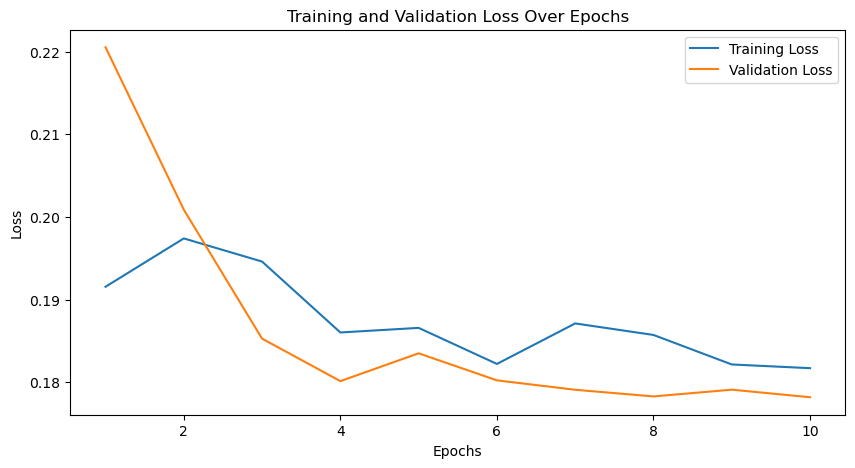

In [29]:
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [41]:
import random
import torch

# Function to print predicted bounding boxes and scores
def print_predictions(model, test_loader, device, score_threshold=0):
    model.eval()
    
    num_images = 10  # Number of images to print predictions for
    images_processed = 0

    for images, targets in test_loader:
        images = list(image.to(device) for image in images)
        outputs = model(images)

        # Move images and targets back to CPU for debugging and plotting
        images = [image.cpu().numpy().transpose((1, 2, 0)) for image in images]
        targets = [{k: v.cpu() for k, v in t.items()} for t in targets]
        outputs = [{k: v.cpu() for k, v in t.items()} for t in outputs]

        for idx in range(len(images)):
            if images_processed >= num_images:
                break

            print(f"Image {images_processed + 1}:")
            if 'boxes' in outputs[idx]:
                pred_boxes = outputs[idx]['boxes']
                pred_scores = outputs[idx]['scores']
                pred_labels = outputs[idx]['labels']

                # Filter out background predictions
                keep = pred_labels == 1  # Assuming label 1 is for the object and 0 is for the background
                pred_boxes = pred_boxes[keep]
                pred_scores = pred_scores[keep]

                # Further filter by confidence score
                keep = pred_scores >= score_threshold
                pred_boxes = pred_boxes[keep]
                pred_scores = pred_scores[keep]

                print(f"  Predicted boxes: {pred_boxes}")
                print(f"  Predicted scores: {pred_scores}")
            else:
                print("  No predicted boxes found")

            images_processed += 1

        if images_processed >= num_images:
            break

# Example usage
print_predictions(model, test_loader, device)

Image 1:
  Predicted boxes: tensor([], size=(0, 4), grad_fn=<IndexBackward0>)
  Predicted scores: tensor([], grad_fn=<IndexBackward0>)
Image 2:
  Predicted boxes: tensor([], size=(0, 4), grad_fn=<IndexBackward0>)
  Predicted scores: tensor([], grad_fn=<IndexBackward0>)
Image 3:
  Predicted boxes: tensor([[233.1383, 255.1520, 275.8012, 290.4488],
        [236.0143, 257.7216, 257.0957, 286.6114]], grad_fn=<IndexBackward0>)
  Predicted scores: tensor([0.1541, 0.0587], grad_fn=<IndexBackward0>)
Image 4:
  Predicted boxes: tensor([[241.3626, 256.1372, 277.3859, 290.2679],
        [240.0285, 256.9294, 270.4097, 277.5441],
        [215.3352, 247.3060, 274.2635, 288.7834],
        [235.1245, 253.9122, 263.1097, 285.6506],
        [204.2471, 252.5560, 248.5094, 281.1637]], grad_fn=<IndexBackward0>)
  Predicted scores: tensor([0.6649, 0.0785, 0.0692, 0.0620, 0.0594], grad_fn=<IndexBackward0>)
Image 5:
  Predicted boxes: tensor([[247.1892, 125.2482, 312.8375, 168.4076],
        [246.1432, 132.289

In [ ]:

def compute_iou(box1, box2):
    """Compute IoU between two boxes."""
    x1_max = max(box1[0], box2[0])
    y1_max = max(box1[1], box2[1])
    x2_min = min(box1[2], box2[2])
    y2_min = min(box1[3], box2[3])

    intersection = max(0, x2_min - x1_max) * max(0, y2_min - y1_max)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = box1_area + box2_area - intersection

    return intersection / union if union != 0 else 0

def plot_image_with_boxes(image, gt_boxes, pred_box, ax):
    ax.imshow(image)
    # Plot ground truth boxes in blue
    for box in gt_boxes:
        xmin, ymin, xmax, ymax = box
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='blue', linewidth=2, label='Ground Truth')
        ax.add_patch(rect)
    # Plot predicted box in red
    if pred_box is not None:
        xmin, ymin, xmax, ymax = pred_box
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='red', linewidth=2, label='Prediction')
        ax.add_patch(rect)
    ax.axis('off')

    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    ax.legend(unique_labels.values(), unique_labels.keys())

def visualize_predictions(model, test_loader, device, score_threshold=0.001):
    model.eval()

    for images, targets in test_loader:
        images = list(image.to(device) for image in images)
        outputs = model(images)

        # Move images and targets back to CPU for debugging and plotting
        images = [image.cpu().detach().numpy().transpose((1, 2, 0)) for image in images]
        targets = [{k: v.cpu() for k, v in t.items()} for t in targets]
        outputs = [{k: v.cpu().detach() for k, v in t.items()} for t in outputs]

        for idx in range(len(images)):
            print(f"Image {idx + 1}:")
            if 'boxes' in outputs[idx]:
                pred_boxes = outputs[idx]['boxes']
                pred_scores = outputs[idx]['scores']
                pred_labels = outputs[idx]['labels']

                # Filter out background predictions
                keep = pred_labels == 1  # Assuming label 1 is for the object and 0 is for the background
                pred_boxes = pred_boxes[keep]
                pred_scores = pred_scores[keep]

                # Further filter by confidence score
                keep = pred_scores >= score_threshold
                pred_boxes = pred_boxes[keep]
                pred_scores = pred_scores[keep]

                if len(pred_boxes) > 0:
                    # Compute IoU and find the box with the highest IoU with any ground truth box
                    gt_boxes = targets[idx]['boxes'].detach().numpy()
                    best_iou = 0
                    best_box = None
                    for pred_box in pred_boxes:
                        for gt_box in gt_boxes:
                            iou = compute_iou(pred_box.numpy(), gt_box)
                            if iou > best_iou:
                                best_iou = iou
                                best_box = pred_box

                    print(f"  Predicted box with highest IoU: {best_box}")
                    print(f"  Predicted scores: {pred_scores}")
                    
                    # Plot the images with ground truth and the best predicted box
                    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
                    plot_image_with_boxes(images[idx], gt_boxes, best_box.detach().numpy() if best_box is not None else None, ax)
                    plt.show()
                else:
                    print("  No high-confidence predicted boxes found")
            else:
                print("  No predicted boxes found")

# Example usage
visualize_predictions(model, test_loader, device)

In [10]:
def compute_iou(box1, box2):
    """Compute IoU between two boxes."""
    x1_max = max(box1[0], box2[0])
    y1_max = max(box1[1], box2[1])
    x2_min = min(box1[2], box2[2])
    y2_min = min(box1[3], box2[3])

    intersection = max(0, x2_min - x1_max) * max(0, y2_min - y1_max)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = box1_area + box2_area - intersection

    return intersection / union if union != 0 else 0

def precision_recall_f1(pred_boxes, gt_boxes, iou_threshold=0.5):
    tp, fp, fn = 0, 0, 0

    for pred_box in pred_boxes:
        iou_max = 0
        for gt_box in gt_boxes:
            iou = compute_iou(pred_box, gt_box)
            if iou > iou_max:
                iou_max = iou
        if iou_max >= iou_threshold:
            tp += 1
        else:
            fp += 1

    fn = len(gt_boxes) - tp

    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    return precision, recall, f1

def average_precision(precisions, recalls):
    """Calculate the Average Precision (AP) from precision and recall values."""
    precisions = np.concatenate([[0], precisions, [0]])
    recalls = np.concatenate([[0], recalls, [1]])

    for i in range(len(precisions) - 1, 0, -1):
        precisions[i - 1] = max(precisions[i - 1], precisions[i])

    indices = np.where(recalls[1:] != recalls[:-1])[0]
    ap = np.sum((recalls[indices + 1] - recalls[indices]) * precisions[indices + 1])
    return ap

def mean_average_precision(pred_boxes_list, gt_boxes_list, iou_threshold=0.5):
    aps = []

    for i in range(len(pred_boxes_list)):
        pred_boxes = pred_boxes_list[i]
        gt_boxes = gt_boxes_list[i]

        precision, recall, _ = precision_recall_f1(pred_boxes, gt_boxes, iou_threshold)

        precisions = [precision]
        recalls = [recall]

        ap = average_precision(np.array(precisions), np.array(recalls))
        aps.append(ap)

    mAP = np.mean(aps)
    return mAP


True Positive (TP):

A predicted bounding box is considered a true positive if it matches a ground truth bounding box with an IoU greater than or equal to the specified threshold (e.g., 0.5).
Each ground truth bounding box should be matched to only one predicted bounding box.
False Positive (FP):

A predicted bounding box is considered a false positive if it does not match any ground truth bounding box with an IoU greater than or equal to the specified threshold.
This can occur if the predicted box overlaps with no ground truth box or if the IoU is below the threshold.
False Negative (FN):

A ground truth bounding box is considered a false negative if it does not have any matching predicted bounding box with an IoU greater than or equal to the specified threshold.
This indicates a missed detection.